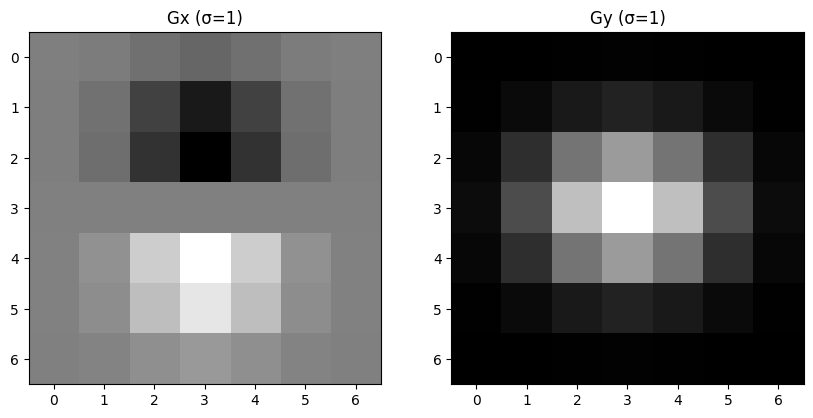

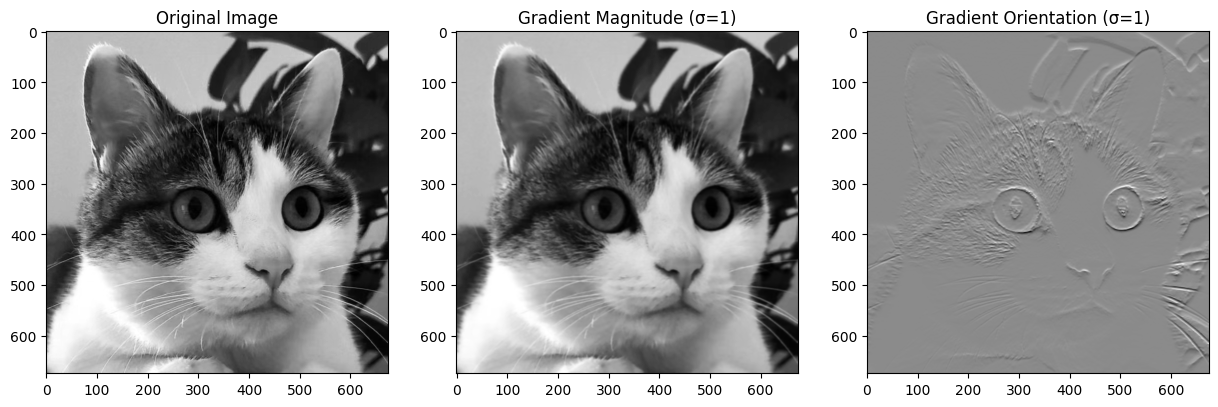

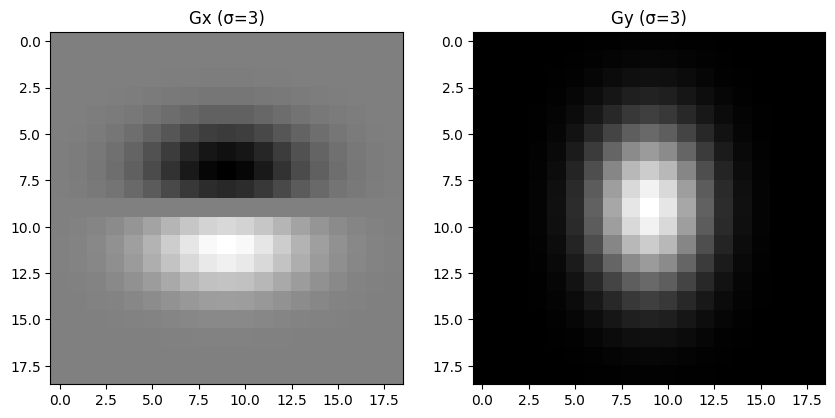

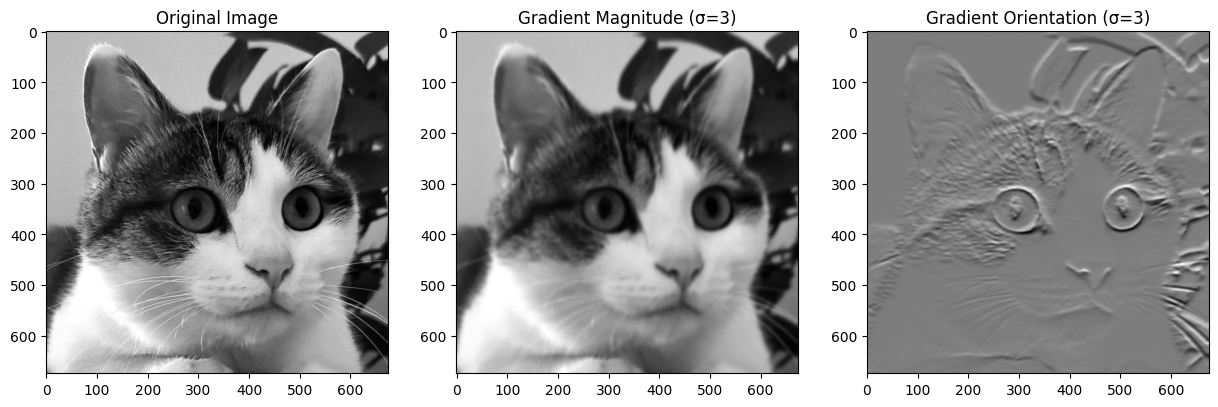

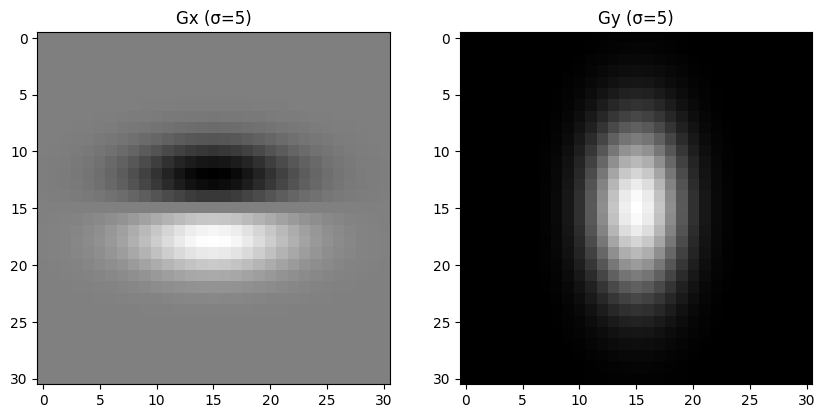

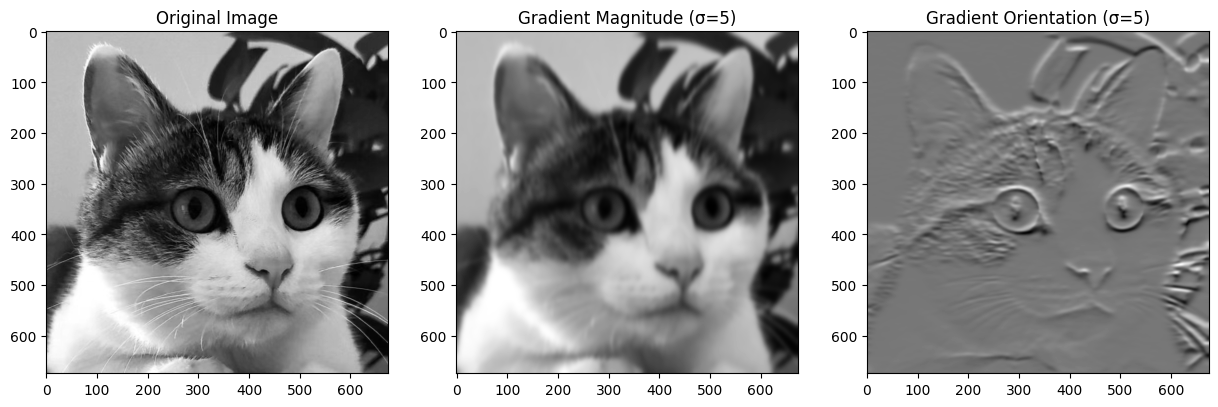

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def gaussian_derivative_kernels(sigma):
    size = int(2 * np.ceil(3 * sigma) + 1)
    gaussian = cv2.getGaussianKernel(size, sigma)
    gaussian_derivative = cv2.getDerivKernels(1, 0, size, True)
    Gx = gaussian_derivative[0] * gaussian.T
    Gy = gaussian * gaussian_derivative[1].T
    return Gx, Gy

def compute_gradients(img, sigma):
    Gx, Gy = gaussian_derivative_kernels(sigma)
    Ix = cv2.filter2D(img, cv2.CV_64F, Gx)
    Iy = cv2.filter2D(img, cv2.CV_64F, Gy)
    return Ix, Iy

def compute_magnitude_and_orientation(Ix, Iy):
    magnitude = np.sqrt(Ix**2 + Iy**2)
    orientation = np.arctan2(Iy, Ix)
    return magnitude, orientation

def visualize_results(img, magnitude, orientation, sigma):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.subplot(1, 3, 2)
    plt.imshow(magnitude, cmap='gray')
    plt.title(f'Gradient Magnitude (σ={sigma})')
    plt.subplot(1, 3, 3)
    plt.imshow(orientation, cmap='gray')
    plt.title(f'Gradient Orientation (σ={sigma})')
    plt.savefig(f'Gradient Orientation (σ={sigma})')
    plt.show()

def visualize_gaussian_kernels(sigma):
    Gx, Gy = gaussian_derivative_kernels(sigma)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(Gx, cmap='gray')
    plt.title(f'Gx (σ={sigma})')
    plt.subplot(1, 2, 2)
    plt.imshow(Gy, cmap='gray')
    plt.title(f'Gy (σ={sigma})')
    plt.savefig(f'Gy (σ={sigma})')
    plt.show()

img = cv2.imread('cat.jpg', cv2.IMREAD_GRAYSCALE)

sigmas = [1, 3, 5]

for sigma in sigmas:
    # 可视化高斯核
    visualize_gaussian_kernels(sigma)
    
    # 计算梯度
    Ix, Iy = compute_gradients(img, sigma)
    magnitude, orientation = compute_magnitude_and_orientation(Ix, Iy)
    
    # 可视化结果
    visualize_results(img, magnitude, orientation, sigma)


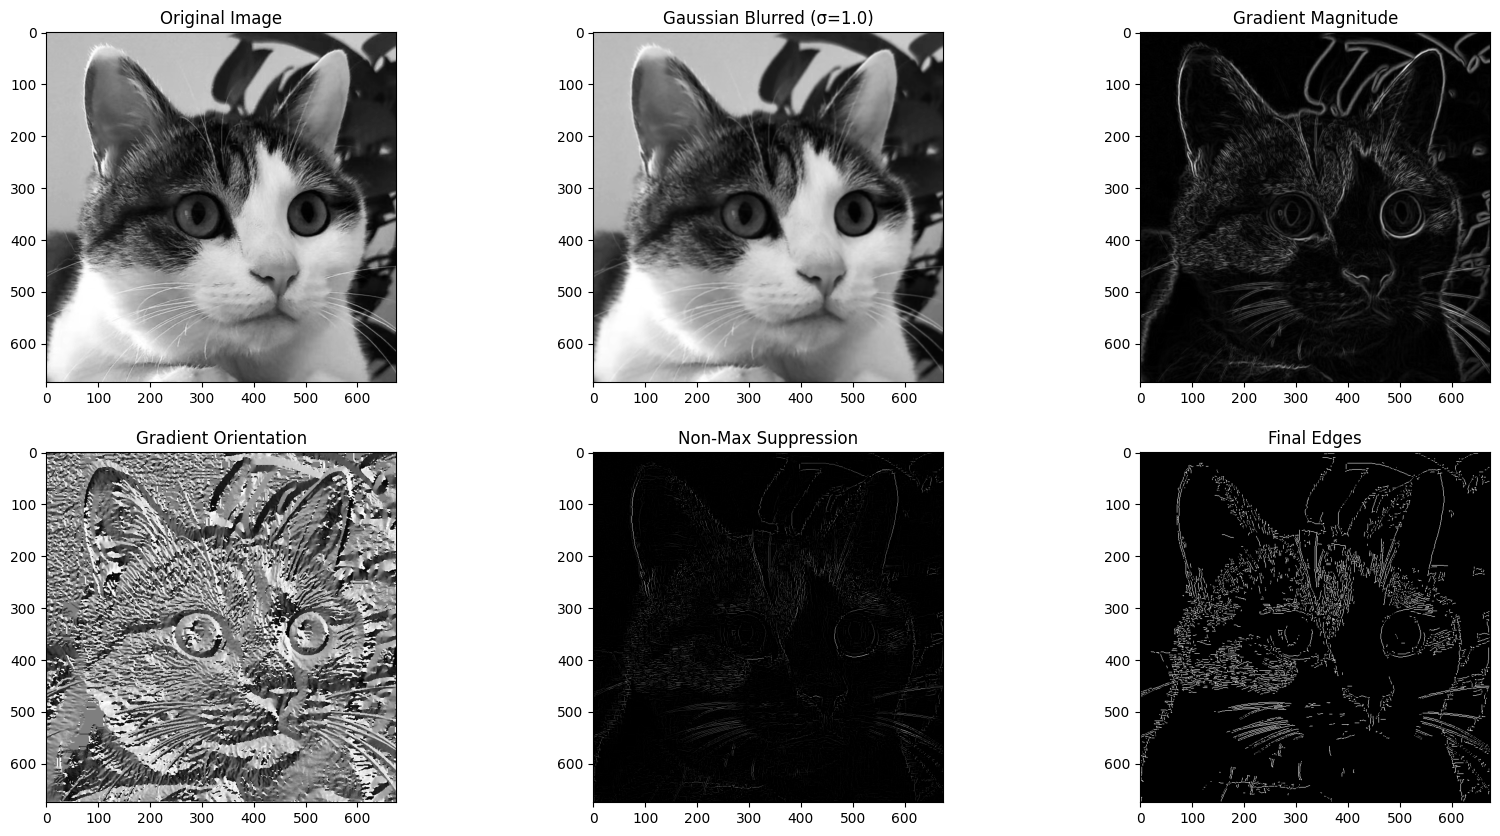

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def gaussian_blur(img, sigma):
    return cv2.GaussianBlur(img, (0, 0), sigma)

def compute_gradients(img):
    Ix = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(Ix**2 + Iy**2)
    orientation = np.arctan2(Iy, Ix)
    return magnitude, orientation

def non_max_suppression(magnitude, orientation):
    rows, cols = magnitude.shape
    suppressed = np.zeros((rows, cols), dtype=np.float32)
    angle = orientation * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, rows-1):
        for j in range(1, cols-1):
            q = 255
            r = 255
            
            # angle 0
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = magnitude[i, j+1]
                r = magnitude[i, j-1]
            # angle 45
            elif 22.5 <= angle[i,j] < 67.5:
                q = magnitude[i+1, j-1]
                r = magnitude[i-1, j+1]
            # angle 90
            elif 67.5 <= angle[i,j] < 112.5:
                q = magnitude[i+1, j]
                r = magnitude[i-1, j]
            # angle 135
            elif 112.5 <= angle[i,j] < 157.5:
                q = magnitude[i-1, j-1]
                r = magnitude[i+1, j+1]

            if (magnitude[i,j] >= q) and (magnitude[i,j] >= r):
                suppressed[i,j] = magnitude[i,j]
            else:
                suppressed[i,j] = 0

    return suppressed

def double_threshold(img, lowThreshold, highThreshold):
    highThreshold = img.max() * highThreshold
    lowThreshold = highThreshold * lowThreshold
    
    res = np.zeros_like(img)
    strong = np.int32(255)
    weak = np.int32(100)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return res, weak, strong

def edge_tracking(img, weak, strong=255):
    rows, cols = img.shape
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            if img[i, j] == weak:
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img

img = cv2.imread('cat.jpg', cv2.IMREAD_GRAYSCALE)
sigma = 1.0
lowThreshold = 0.05
highThreshold = 0.15

# 高斯滤波
blurred_img = gaussian_blur(img, sigma)

# 计算梯度
magnitude, orientation = compute_gradients(blurred_img)

# 非最大值抑制
nms_img = non_max_suppression(magnitude, orientation)

# 双阈值
threshold_img, weak, strong = double_threshold(nms_img, lowThreshold, highThreshold)

# 边缘连接
final_img = edge_tracking(threshold_img, weak, strong)

# 可视化结果
plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(2, 3, 2)
plt.imshow(blurred_img, cmap='gray')
plt.title(f'Gaussian Blurred (σ={sigma})')
plt.subplot(2, 3, 3)
plt.imshow(magnitude, cmap='gray')
plt.title('Gradient Magnitude')
plt.subplot(2, 3, 4)
plt.imshow(orientation, cmap='gray')
plt.title('Gradient Orientation')
plt.subplot(2, 3, 5)
plt.imshow(nms_img, cmap='gray')
plt.title('Non-Max Suppression')
plt.subplot(2, 3, 6)
plt.imshow(final_img, cmap='gray')
plt.title('Final Edges')
plt.savefig('canny')
plt.show()


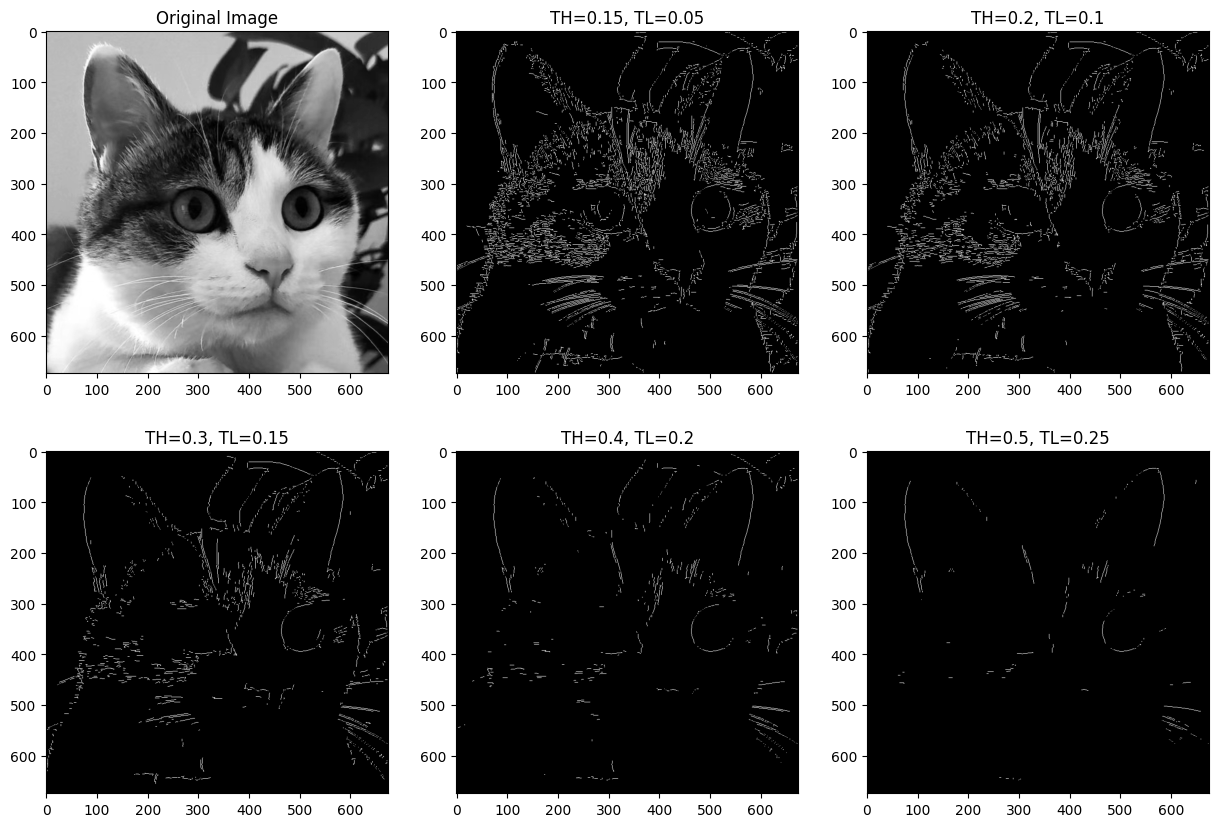

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def gaussian_blur(img, sigma):
    return cv2.GaussianBlur(img, (0, 0), sigma)

def compute_gradients(img):
    Ix = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(Ix**2 + Iy**2)
    orientation = np.arctan2(Iy, Ix)
    return magnitude, orientation

def non_max_suppression(magnitude, orientation):
    rows, cols = magnitude.shape
    suppressed = np.zeros((rows, cols), dtype=np.float32)
    angle = orientation * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, rows-1):
        for j in range(1, cols-1):
            q = 255
            r = 255
            
            # angle 0
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = magnitude[i, j+1]
                r = magnitude[i, j-1]
            # angle 45
            elif 22.5 <= angle[i,j] < 67.5:
                q = magnitude[i+1, j-1]
                r = magnitude[i-1, j+1]
            # angle 90
            elif 67.5 <= angle[i,j] < 112.5:
                q = magnitude[i+1, j]
                r = magnitude[i-1, j]
            # angle 135
            elif 112.5 <= angle[i,j] < 157.5:
                q = magnitude[i-1, j-1]
                r = magnitude[i+1, j+1]

            if (magnitude[i,j] >= q) and (magnitude[i,j] >= r):
                suppressed[i,j] = magnitude[i,j]
            else:
                suppressed[i,j] = 0

    return suppressed

def double_threshold(img, lowThreshold, highThreshold):
    highThreshold = img.max() * highThreshold
    lowThreshold = highThreshold * lowThreshold
    
    res = np.zeros_like(img)
    strong = np.int32(255)
    weak = np.int32(100)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return res, weak, strong

def edge_tracking(img, weak, strong=255):
    rows, cols = img.shape
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            if img[i, j] == weak:
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img

def canny_edge_detection(img, sigma, lowThreshold, highThreshold):
    # 高斯滤波
    blurred_img = gaussian_blur(img, sigma)

    # 计算梯度
    magnitude, orientation = compute_gradients(blurred_img)

    # 非最大值抑制
    nms_img = non_max_suppression(magnitude, orientation)

    # 双阈值
    threshold_img, weak, strong = double_threshold(nms_img, lowThreshold, highThreshold)

    # 边缘连接
    final_img = edge_tracking(threshold_img, weak, strong)

    return final_img

if __name__ == "__main__":
    img = cv2.imread('cat.jpg', cv2.IMREAD_GRAYSCALE)
    sigma = 1.0
    threshold_params = [(0.05, 0.15), (0.1, 0.2), (0.15, 0.3), (0.2, 0.4), (0.25,0.5)]

    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')

    for i, (lowThreshold, highThreshold) in enumerate(threshold_params, 2):
        final_img = canny_edge_detection(img, sigma, lowThreshold, highThreshold)
        plt.subplot(2, 3, i)
        plt.imshow(final_img, cmap='gray')
        plt.title(f'TH={highThreshold}, TL={lowThreshold}')
        plt.imsave(f'canny_TH={highThreshold}_TL={lowThreshold}.png', final_img, cmap='gray')

    plt.show()


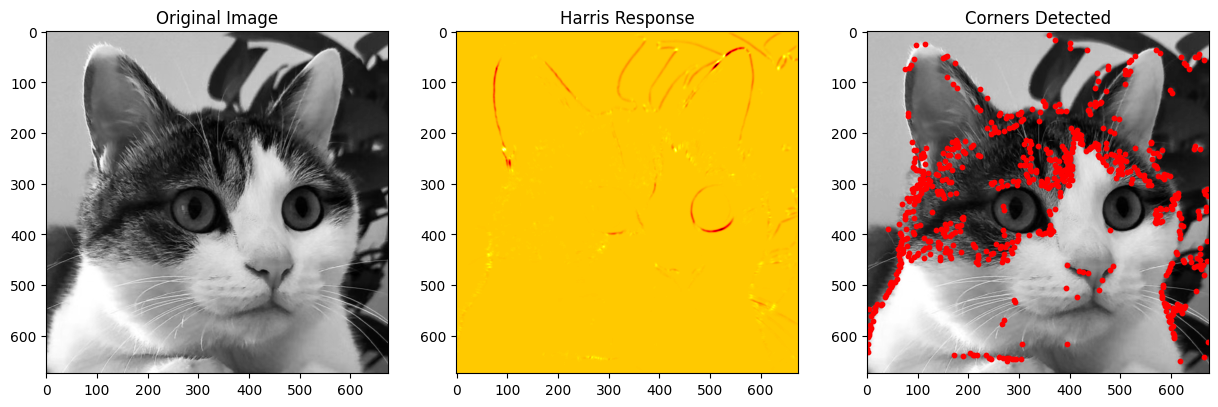

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def harris_corner_detection(image, sigma, alpha=0.04, threshold=1e-2):
    blurred_img = cv2.GaussianBlur(image, (0, 0), sigma)
    
    Ix = cv2.Sobel(blurred_img, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(blurred_img, cv2.CV_64F, 0, 1, ksize=3)
    
    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix * Iy
    
    Sxx = cv2.GaussianBlur(Ixx, (0, 0), sigma)
    Syy = cv2.GaussianBlur(Iyy, (0, 0), sigma)
    Sxy = cv2.GaussianBlur(Ixy, (0, 0), sigma)
    
    detM = Sxx * Syy - Sxy ** 2
    traceM = Sxx + Syy
    
    R = detM - alpha * (traceM ** 2)
    
    corners = np.zeros_like(R)
    corners[R > threshold * R.max()] = 255
    
    corners = non_max_suppression(R, corners)
    
    return R, corners

def non_max_suppression(R, corners):
    window_size = 3
    half_size = window_size // 2
    rows, cols = R.shape
    result = np.zeros_like(corners)
    
    for i in range(half_size, rows - half_size):
        for j in range(half_size, cols - half_size):
            if corners[i, j] == 255:
                window = R[i - half_size:i + half_size + 1, j - half_size:j + half_size + 1]
                if R[i, j] == np.max(window):
                    result[i, j] = 255
    return result

img = cv2.imread('cat.jpg', cv2.IMREAD_GRAYSCALE)

sigma = 1.5
alpha = 0.04
threshold = 1e-2
R, corners = harris_corner_detection(img, sigma, alpha, threshold)

# 可视化结果
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(R, cmap='hot')
plt.title('Harris Response')
plt.subplot(1, 3, 3)
plt.imshow(img, cmap='gray')
plt.scatter(np.nonzero(corners)[1], np.nonzero(corners)[0], marker='o', color='red', s=10)
plt.title('Corners Detected')
plt.savefig('Corners Detected.jpg')
plt.show()


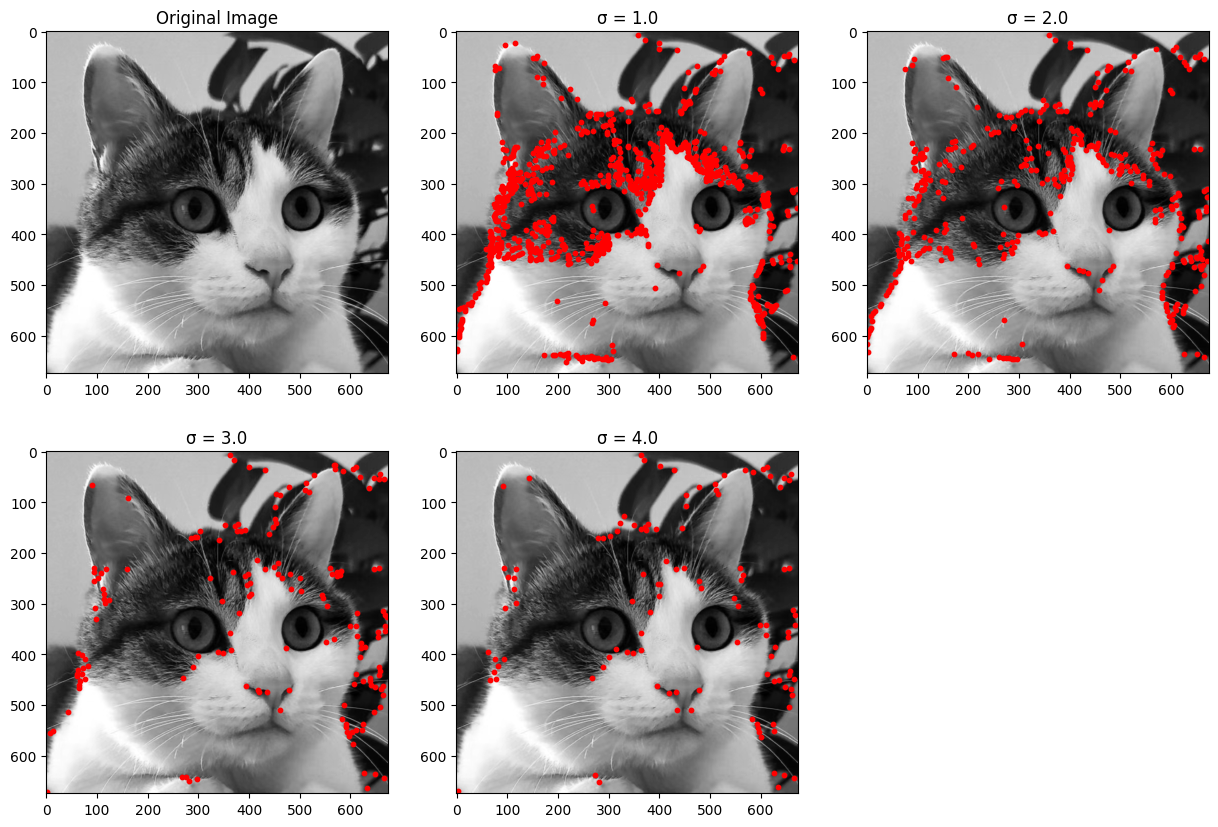

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def harris_corner_detection(image, sigma, alpha=0.04, threshold=1e-2):
    blurred_img = cv2.GaussianBlur(image, (0, 0), sigma)
    
    Ix = cv2.Sobel(blurred_img, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(blurred_img, cv2.CV_64F, 0, 1, ksize=3)
    
    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix * Iy
    
    Sxx = cv2.GaussianBlur(Ixx, (0, 0), sigma)
    Syy = cv2.GaussianBlur(Iyy, (0, 0), sigma)
    Sxy = cv2.GaussianBlur(Ixy, (0, 0), sigma)
    
    detM = Sxx * Syy - Sxy ** 2
    traceM = Sxx + Syy
    
    R = detM - alpha * (traceM ** 2)
    
    corners = np.zeros_like(R)
    corners[R > threshold * R.max()] = 255
    
    corners = non_max_suppression(R, corners)
    
    return R, corners

def non_max_suppression(R, corners):
    window_size = 3
    half_size = window_size // 2
    rows, cols = R.shape
    result = np.zeros_like(corners)
    
    for i in range(half_size, rows - half_size):
        for j in range(half_size, cols - half_size):
            if corners[i, j] == 255:
                window = R[i - half_size:i + half_size + 1, j - half_size:j + half_size + 1]
                if R[i, j] == np.max(window):
                    result[i, j] = 255
    return result

img = cv2.imread('cat.jpg', cv2.IMREAD_GRAYSCALE)

# Harris角点检测
sigma_values = [1.0, 2.0, 3.0, 4.0]
alpha = 0.04
threshold = 1e-2

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

for i, sigma in enumerate(sigma_values, start=2):
    _, corners = harris_corner_detection(img, sigma, alpha, threshold)
    plt.subplot(2, 3, i)
    plt.imshow(img, cmap='gray')
    plt.scatter(np.nonzero(corners)[1], np.nonzero(corners)[0], marker='o', color='red', s=10)
    plt.title(f'σ = {sigma}')

plt.show()


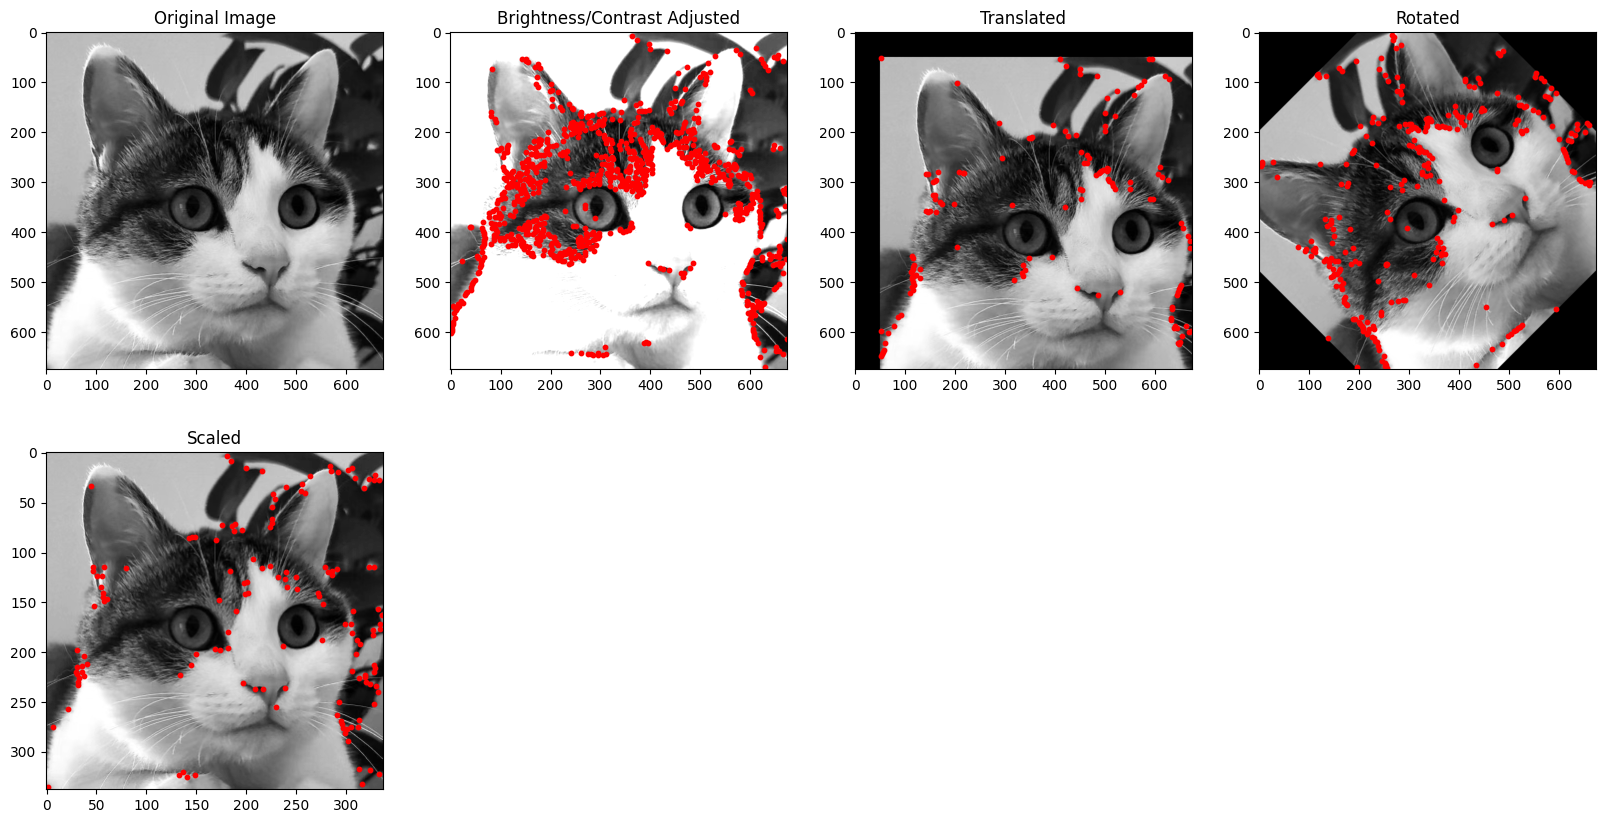

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def harris_corner_detection(image, sigma, alpha=0.04, threshold=1e-2):
    blurred_img = cv2.GaussianBlur(image, (0, 0), sigma)
    
    Ix = cv2.Sobel(blurred_img, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(blurred_img, cv2.CV_64F, 0, 1, ksize=3)
    
    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix * Iy
    
    Sxx = cv2.GaussianBlur(Ixx, (0, 0), sigma)
    Syy = cv2.GaussianBlur(Iyy, (0, 0), sigma)
    Sxy = cv2.GaussianBlur(Ixy, (0, 0), sigma)
    
    detM = Sxx * Syy - Sxy ** 2
    traceM = Sxx + Syy
    
    R = detM - alpha * (traceM ** 2)
    
    corners = np.zeros_like(R)
    corners[R > threshold * R.max()] = 255
    
    corners = non_max_suppression(R, corners)
    
    return R, corners

def non_max_suppression(R, corners):
    window_size = 3
    half_size = window_size // 2
    rows, cols = R.shape
    result = np.zeros_like(corners)
    
    for i in range(half_size, rows - half_size):
        for j in range(half_size, cols - half_size):
            if corners[i, j] == 255:
                window = R[i - half_size:i + half_size + 1, j - half_size:j + half_size + 1]
                if R[i, j] == np.max(window):
                    result[i, j] = 255
    return result

def adjust_brightness_contrast(image, alpha=1.0, beta=0):
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

def apply_geometric_transformations(image):
    rows, cols = image.shape
    M_translate = np.float32([[1, 0, 50], [0, 1, 50]])
    translated_img = cv2.warpAffine(image, M_translate, (cols, rows))
    
    M_rotate = cv2.getRotationMatrix2D((cols / 2, rows / 2), 45, 1)
    rotated_img = cv2.warpAffine(image, M_rotate, (cols, rows))
    
    scaled_img = cv2.resize(image, None, fx=0.5, fy=0.5)
    return translated_img, rotated_img, scaled_img

def plot_results(original_img, transformed_imgs, corners_list, titles):
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 4, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')
    for i, (img, corners) in enumerate(zip(transformed_imgs, corners_list), start=2):
        plt.subplot(2, 4, i)
        plt.imshow(img, cmap='gray')
        plt.scatter(np.nonzero(corners)[1], np.nonzero(corners)[0], marker='o', color='red', s=10)
        plt.title(titles[i-2])
    plt.savefig('Corners_Detected.jpg')
    plt.show()

# 读取图像
img = cv2.imread('cat.jpg', cv2.IMREAD_GRAYSCALE)

# Harris角点检测
sigma = 1.5
alpha = 0.04
threshold = 1e-2
_, original_corners = harris_corner_detection(img, sigma, alpha, threshold)

# 调整亮度和对比度
bright_img = adjust_brightness_contrast(img, alpha=1.5, beta=50)
_, bright_corners = harris_corner_detection(bright_img, sigma, alpha, threshold)

# 几何变换
translated_img, rotated_img, scaled_img = apply_geometric_transformations(img)
_, translated_corners = harris_corner_detection(translated_img, sigma, alpha, threshold)
_, rotated_corners = harris_corner_detection(rotated_img, sigma, alpha, threshold)
_, scaled_corners = harris_corner_detection(scaled_img, sigma, alpha, threshold)

# 绘制结果
transformed_imgs = [bright_img, translated_img, rotated_img, scaled_img]
corners_list = [bright_corners, translated_corners, rotated_corners, scaled_corners]
titles = ['Brightness/Contrast Adjusted', 'Translated', 'Rotated', 'Scaled']
plot_results(img, transformed_imgs, corners_list, titles)
